## Vibes Lab Mask Automation Pipeline Development (Draft 2)

Second trial with input as nii files. 

In [ ]:
import nibabel as nib
import numpy as np
nifti = nib.load("/home/smooi/vibes_auto_pipe/data/Cc_just_bet_nifti/Cc106_t2bet.nii")
# retrieve nifti data
data = nifti.get_fdata()
data = (data - np.min(data)) / (np.max(data) - np.min(data)) * 255.0
data = data.astype(np.uint8)  # Convert to 8-bit unsigned integers

In [2]:
print(type(data))

<class 'numpy.ndarray'>


In [4]:
# config to use the gpu of the server 
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

2025-02-14 13:37:31.147942: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-12.6/lib64
2025-02-14 13:37:31.147993: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-02-14 13:37:32.620335: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2025-02-14 13:37:32.621963: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2025-02-14 13:37:32.776060: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-02-14 13:37:32.776121: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be runni

In [5]:
print(data.shape) # (96, 96, 48) # there are 48 slices
import cv2
import os
output_dir = "/home/smooi/vibes_auto_pipe/output"

# Iterate through the slices 
for i in range(data.shape[2]): #iter thru 1 to 48 
    slice_ = data[:, :, i] # 2D slices
    resized_slice = cv2.resize(slice_, (160, 160), interpolation=cv2.INTER_AREA)
    # rotate the image by 90 degrees counterclockwise 
    rotated_slice = cv2.rotate(resized_slice, cv2.ROTATE_90_COUNTERCLOCKWISE)  
    # Scale to Full Grayscale Range [0, 255]
    img_max_range = rotated_slice.max()
    output_img = (rotated_slice / img_max_range) * 255
    output_path = os.path.join(output_dir, f"{i:03d}.png") 
    cv2.imwrite(output_path, output_img)
    
# retrieve the original shape of the image here 
# so that we can reshape it back to the original shape at the end in Python code
w = data.shape[0]
h = data.shape[1]
s = data.shape[2]

(96, 96, 48)


[ WARN:0@0.043] global loadsave.cpp:848 imwrite_ Unsupported depth image for selected encoder is fallbacked to CV_8U.


In [6]:
# load a png file and explore its min and max
picture = "/home/smooi/vibes_auto_pipe/output/001.png"

# chatgpt's code to examine a png file
image = cv2.imread(picture, cv2.IMREAD_UNCHANGED)

# Display basic information
print(f"Image Shape: {image.shape}")  # Dimensions: (height, width, channels)
print(f"Data Type: {image.dtype}")    # Pixel data type (e.g., uint8)
print(f"Min Pixel Value: {image.min()}")  # Minimum pixel intensity
print(f"Max Pixel Value: {image.max()}")  # Maximum pixel intensity

# Currently, there's no channel info
# It is also observed that the pixel range is not Scale to Full Grayscale Range [0, 255]

Image Shape: (160, 160)
Data Type: uint8
Min Pixel Value: 0
Max Pixel Value: 255


In [7]:
import tensorflow as tf
mydir = "/home/smooi/vibes_auto_pipe/output"

def prepare_image_for_tf(img):
    brain_img = tf.io.read_file(img)
    brain_img = tf.io.decode_png(brain_img, channels=1) # brain img channels=1 greyscale
    brain_img = tf.image.resize(brain_img, [160, 160]) # Necessary since inputs may be varying in size from different trials
    brain_img = tf.cast(brain_img, tf.float32)  
    
    return brain_img

# make this to be a global variable 
store_filenames = []
def retrieve_n_sort(directory):
    # List Comprehensions
    filenames = [filename for filename in os.listdir(directory) if filename.endswith(".png")]
    # lambda func
    filenames.sort(key=lambda x: int(x.split('.')[0].split('/')[-1]))  # Sort by slice number
    return filenames


# Process all images in the directory
def process_all_images(directory):
    sorted_filenames = retrieve_n_sort(directory)
    image_tensors = [prepare_image_for_tf(os.path.join(directory, filename)) for filename in sorted_filenames]
    return tf.stack(image_tensors)  # Stack into a batch tensor

# Process images in the directory
image_batch = process_all_images(mydir)
print(f"Processed Image Batch Shape: {image_batch.shape}") # Processed Image Batch Shape: (48, 160, 160, 1)  48 refers to the batch size 


Processed Image Batch Shape: (56, 160, 160, 1)


2025-02-14 13:39:26.374220: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set


In [ ]:
# # let's reexamine the shape and intensity of the images
# for brain_img in image_batch:
    
#     print("Brain Image range: Min =", tf.reduce_min(brain_img).numpy(), 
#           "Max =", tf.reduce_max(brain_img).numpy())
    
# yes, its min = 0 and max = 255 now. 

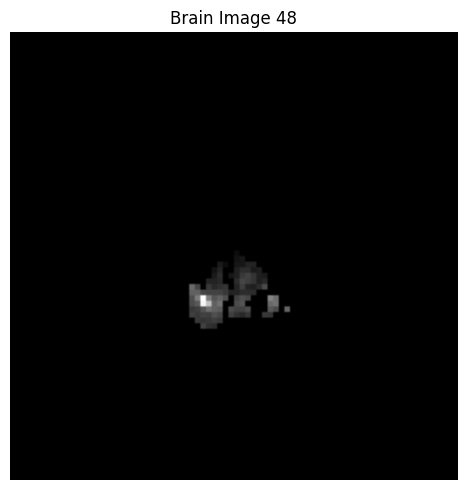

In [8]:
# show brain figures that we want to visualize
# View 10 random brain image and mask from training data:
import matplotlib.pyplot as plt
plt.figure(figsize=(5,5))

for image in image_batch:  # Let's examine five pairs
    # i: represent index var for each iteration
    # Show brain image
    squeezed_brain_img = tf.squeeze(image, axis=-1)  # Remove the channel dimension (which indicates greyscale)
    plt.imshow(squeezed_brain_img, cmap="gray")
    plt.title(f"Brain Image {i + 1}")
    plt.axis("off")
    plt.tight_layout() 
    # plt.show() 



In [9]:
import tensorflow as tf
print(tf.__version__)
from tensorflow.keras.models import load_model
from loss_funcs import loss_function

# create the instance
my_loss_func = loss_function()

dice_coefficient = my_loss_func.dice_coefficient
dice_loss = my_loss_func.dice_loss


# Load the train model:
saved_model_path = "/home/smooi/vibes_auto_pipe/unet_w_aug.h5"
model = load_model(saved_model_path, custom_objects={"dice_loss": dice_loss, "dice_coefficient": dice_coefficient})
print("Model Loaded Successfully!")


2.4.0
Your loss function class initiate successfully!
Model Loaded Successfully!


In [10]:
# Make the predictions 
predictions = model.predict(image_batch)

2025-02-14 13:39:41.279369: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2025-02-14 13:39:41.281861: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3609600000 Hz


In [11]:
binary_predictions = (predictions > 0.5).astype(int)
predicted_mask = binary_predictions.squeeze()

In [ ]:
# import matplotlib.pyplot as plt
# from matplotlib.backends.backend_pdf import PdfPages

# with PdfPages('trial1.pdf') as pdf:
#     for image in image_batch:  # Iterate over individual images
#         # Expand dimensions to add batch size of 1 (for single-image prediction)
#         image_expanded = np.expand_dims(image, axis=0)  # Shape: (1, 160, 160, 1)

#         # Predict the mask
#         predicted_mask = model.predict(image_expanded)  # Output shape: (1, 160, 160, 1)
#         predicted_mask = (predicted_mask > 0.5).astype(int).squeeze()  # Remove batch dimension

#         # Plot input image and predicted mask
#         plt.figure(figsize=(10, 5))

#         # Input image
#         plt.subplot(1, 2, 1)
#         plt.title("Input Image")
#         plt.imshow(image[:, :, 0], cmap='gray')  # Original shape: (160, 160, 1)
#         plt.axis('off')

#         # Predicted mask
#         plt.subplot(1, 2, 2)
#         plt.title("Predicted Mask")
#         plt.imshow(predicted_mask, cmap='gray')  # Predicted mask shape: (160, 160)
#         plt.axis('off')

#         # Save the figure to the PDF
#         print("Saving figure...")
#         pdf.savefig()
#         plt.close()


In [ ]:
print(predicted_mask.shape)
predicted_mask_reordered = np.transpose(predicted_mask, (1, 2, 0))
print(predicted_mask_reordered.shape)

# In order to transfer this back to the nii file,
# we have to follow the original nifti file format,
# which should have the slice number at the end (e.g. (160, 160, 48))

# Create an nifti object
affine = nifti.affine
new_nifti = nib.Nifti1Image(predicted_mask_reordered, affine)
saved_dir = "/home/smooi/vibes_auto_pipe/result/Cc106_t2bet_mask.nii"

# change the format 
nib.save(new_nifti, saved_dir)
# print("NIfTI file saved as 'predicted_masks1.nii'")


(56, 160, 160)
(160, 160, 56)


/home/smooi/miniconda3/envs/tf_env/lib/python3.7/site-packages/ipykernel_launcher.py:11: FutureWarning: Image data has type int64, which may cause incompatibilities with other tools. This will error in NiBabel 5.0. This warning can be silenced by passing the dtype argument to Nifti1Image().
  # This is added back by InteractiveShellApp.init_path()


In [13]:
# verify the aboved saved file
saved_nifti = nib.load(saved_dir)
loaded_data = saved_nifti.get_fdata()

print(f"Loaded NIfTI shape: {loaded_data.shape}")  # Should match your mask shape


Loaded NIfTI shape: (160, 160, 56)
